# Tematsko modeliranje


Tematsko modeliranje (engl. *topic modelling*) je vrsta statističkog modeliranja čiji je cilj pronalaženje tema u okviru korpusa dokumenata. Drugim rečima, u okviru korpusa dokumenata $\mathcal{D}$, tražimo skup tema $ T $ da bismo dokumente mogli adekvatno sortirati. Za razliku od problema klasifikacije teksta, gde je skup tema već poznat, tematsko modeliranje je problem nenadgledanog učenja. Dva osnovna pristupa rešavanju problema tematskog modeliranja jesu LSA i LDA.

## Pretprocesiranje

Da bi se tehnike LSA i LDA mogle koristiti, podaci se moraju pripremiti na odgovarajući način. Prvo što je potrebno uraditi jeste predstavljanje dokumenata preko vektora gde svaka vrednost predstavlja koliko se puta reč nalazi u skupu reči:

$ \textrm{"the throne of the king"} \longrightarrow  
\begin{bmatrix}
    2 \\
    0 \\
    0 \\
    1 \\
    \vdots \\
    1
\end{bmatrix} \in
\begin{bmatrix}
    the \\
    live \\
    reign \\
    throne \\
    \vdots \\
    king
\end{bmatrix} $

Ovde se koristi pristup sa multiskupom reči; svaka reč se svodi na broj pojavljivanja, dok se pozicija reči u tekstu zanemaruje.

Pošto postoji $n$ dokumenata, dobija se matrica reda $N \times k$, gde je $k$ broj reči u biblioteci. Svaki dokument odgovaraće jednom redu rezultujuće matrice:

$\begin{bmatrix}
    \textrm{"the throne of the king"} \\
    \textrm{"a new reign"} \\
    \vdots \\
    \textrm{"long live the king"}
\end{bmatrix}
\longrightarrow
\begin{bmatrix}
    2 & 0 & 0 & 1 & \dots & 1 \\
    0 & 0 & 1 & 0 & \dots & 0 \\
    \vdots & \vdots & \vdots & \vdots &  & \vdots \\
    1 & 1 & 0 & 0 & \dots & 1
\end{bmatrix}$

Primer iznad je dat radi vizuelizacije podataka, ali se iz teksta generalno odbacuju tzv. stop reči (česte reči bez izrazitog značenja poput "*a*" ili "*the*") . Izuzev njih, za reči koje ulaze u sastav skupa se biraju reči koje se najčešće pojavljuju.

Za potrebe demonstriranja će biti korišćen skup podataka "*20 Newsgroup*" u okviru biblioteke `sklearn`.

In [1]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=("headers", "footers", "quotes"))
documents = dataset.data

print(len(documents)) 
print(dataset.target_names)

11314
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Postoji 11314 dokumenata koji pripadaju jednoj od prethodno navedenih 20 grupa vesti. Dalje je potrebno izbrisati sve karaktere koji nisu slova ili razmak; a nakon toga, treba prebaciti sve karaktere u mala slova. Bilo bi poželjno i izbaciti kratke reči (do 3 slova):

In [2]:
import pandas as pd

# Najjednostavniji način da se postigne željenu rezultat je
# da koristimo DataFrame strukturu
news_df = pd.DataFrame({"document":documents})

# Koristimo regex za odstranjivanje svih karaktera koji nisu slova
news_df["document"] = news_df["document"].str.replace("[^a-zA-Z#]", " ")

# Izbacivanje kratkih reci
news_df["document"] = news_df["document"].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

# Pretvaranje svih slova u mala slova
news_df["document"] = news_df["document"].apply(lambda x: x.lower())    

print(news_df.head())

                                            document
0  well sure about story seem biased what disagre...
1  yeah expect people read actually accept hard a...
2  although realize that principle your strongest...
3  notwithstanding legitimate fuss about this pro...
4  well will have change scoring playoff pool unf...


Da bi se pomenuta matrica napravila, može se koristiti objekat `CountVectorizer` u okviru `sklearn` biblioteke. U nastavku će biti korišćen blago modifikovani pristup sa korišćenjem **tfidf** težina, pa će se koristiti `TfidfVectorizer` koji računa težinu svake reči za svaki dokument po sledećoj formuli:

$ w_{i,j} = tf_{i,j} \log{\dfrac{N}{df_j}} $

gde su $ tf_{i,j} $ broj ponavljanja reči $j$ u dokumentu $i$, a $ df_{j} $ broj ponavljanja reči $j$ u svim dokumentima u korpusu.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

M = 1000 # Maksimalni broj kolona
tv = TfidfVectorizer(stop_words="english", max_features=M)

document_term_matrix = tv.fit_transform(news_df["document"])
print(type(document_term_matrix))
print(document_term_matrix.shape)
print(document_term_matrix[0])

<class 'scipy.sparse.csr.csr_matrix'>
(11314, 1000)
  (0, 664)	0.12482699217899616
  (0, 444)	0.15920786810198112
  (0, 497)	0.11606278893174055
  (0, 73)	0.13042573485326867
  (0, 516)	0.13226489554872167
  (0, 366)	0.12704052323102857
  (0, 716)	0.15952691353774057
  (0, 814)	0.1846235059899824
  (0, 732)	0.16381332141612362
  (0, 154)	0.1582696239800608
  (0, 730)	0.16151197900355305
  (0, 712)	0.128507139034102
  (0, 893)	0.0880418781548271
  (0, 477)	0.16834732334900732
  (0, 229)	0.17099938915691926
  (0, 710)	0.16609758611560899
  (0, 388)	0.12393127093119301
  (0, 985)	0.12177290184053344
  (0, 438)	0.34482777905476636
  (0, 532)	0.6620433868499663
  (0, 841)	0.15289850944254976
  (0, 849)	0.1573584484023006
  (0, 867)	0.11171887866892631


Ova matrica se u literaturi često naziva dokument-term matrica (engl. *Document-term matrix*). Primetimo da se ona predstavlja sa CSR modelom koji reprezentuje retke matrice, što ima smisla, jer ova matrica ima malo nenula elemenata u odnosu na njenu veličinu.

## LSA

LSA (engl. *Latent Semantic Analysis*) se zasniva na smanjivanju dimenzionalnosti dobijene dokument-term matrice $D$ uz pomoć singularne dekompozicije:

$ D = U \Sigma V^T $

Da bismo dobili manju dimenziju matrice $D$ možemo napraviti aproksimaciju te matrice tako što ćemo "odseći" deo manje bitnih informacija (po parametru $t$):

$ D \approx U_t {\Sigma}_t V^T_t $

gde su $U_t$, ${\Sigma}_t$ i $V^T_t$ matrice veličina $ N \times t $, $ t \times t $ i $ t \times N $.

U *python*-u, ovo se može izvesti pomoću `TruncatedSVD` objekta iz biblioteke `sklearn`.

In [4]:
from sklearn.decomposition import TruncatedSVD

def LSA(data, t):
    svd_model = TruncatedSVD(n_components=t, algorithm="randomized", random_state=10)
    data = svd_model.fit_transform(data)
    
    return (svd_model.components_, data)

def print_topics(components, vectorizer, n_words):
    #dohvatamo M originalnih tema
    terms = vectorizer.get_feature_names()

    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:n_words]
        sorted_terms = map(lambda x: x[0], sorted_terms)
        
        topics = " ".join(sorted_terms)
        print(f"Topic {i+1}: " + topics)

# Očekujemo 20 tema
components, lsa_data = LSA(document_term_matrix, 20)
print_topics(components, tv, 7)    

Topic 1: just like know people think does good
Topic 2: thanks windows card drive mail file advance
Topic 3: game team year games drive season good
Topic 4: drive scsi disk hard problem drives just
Topic 5: drive know does thanks just scsi drives
Topic 6: just like windows know window does file
Topic 7: just like mail bike thanks chip email
Topic 8: does know chip like clipper card encryption
Topic 9: like card sale good offer video jesus
Topic 10: like drive file files space program sounds
Topic 11: people like card government thanks windows right
Topic 12: think chip clipper encryption good need mail
Topic 13: good problem thanks bike know right window
Topic 14: good know windows people file files sale
Topic 15: space know nasa think year shuttle launch
Topic 16: does israel think israeli right jews sale
Topic 17: good space card thanks does year people
Topic 18: problem people window using year server know
Topic 19: file problem does files people thanks make
Topic 20: right sure mai

### PLSA

PLSA (engl. *Probabilistic Latent Semantic Analysis*) ne koristi SVD dekompoziciju, već se problemu prisupa probabilistički. Ovde želimo da napravimo probabilistički model $P$ tako da za svaki dokument $d$ i reč $w$ važi da $P(d,w)$ odgovara adekvatnom elementu matrice $D$. Formalno, možemo to matematički izraziti na sledeći način:

$ P(d,w) = P(d) \sum_{z} P(z|d) P(w|z) $

U prethodnoj formuli, z predstavlja temu, $P(d)$ je verovatnoća posmatranja dokumenta $d$, $P(z|d)$ je verovatnoća da $z$ bude tema tog dokumenta, a $P(w|z)$ je verovatnoća da se reč $w$ nalazi u dokumentu teme $z$.

PLSA je fleksibilniji model od LSA, ali ima svoje nedostatke: na primer, broj parametara raste linearno sa brojem dokumenata u korpusu, te je ovaj model sklon preprilagođavanju (engl. *overfitting*)

## LDA

LDA (engl. Latent Dirichlet Allocation) je pandan PLSA algoritmu čija je osnova Bajesova verovatnoća. U suštini, koristi se obrnuti pristup: pokušavamo da generišemo dokumente tako što predpostavljamo raspodelu verovatnoće da određena dokument sadrži reči koje pripadaju nekoj temi, kao i raspodelu verovatnoća da neke reči pripadaju određenim temama.

Uvedimo naredne oznake (i podsetimo se starih):

- $t$ — broj tema po dokumentu (fiksirana vrednost)
- $k$ — broj reči u biblioteci
- $N$ — broj dokumenata
- $M$ — broj reči u svakom dokumentu
- $w$ — reč u dokumentu
- $d$ — dokument
- $\mathcal{D}$ — korpus dokumenata
- $z$ — tema koja je predstavljena kao distribucija reči
- $Z$ — sve teme dokumenta

Uzmimo parametar $\alpha$, gde je $ 0 < \alpha < 1 $. Uz pomoć parametra $\alpha$ možemo da generišemo matricu $\theta$ čiji element $\theta_{i,j}$ označava verovatnoću da $i$-ti dokument ima reči koje pripadaju $j$-toj temi.

Slično, uz pomoć parametra $\beta$ generišemo matricu $\phi$, čiji element $\phi_{i,j}$ je jednak verovatnoći da $i$-toj temi pripada $j$-ta reč.

Način na koji generišemo raspodele $\theta$ i $\phi$ je uz pomoć **Dirihleove raspodele**. Ova raspodela uglavnom uzima više parametara, ali će u našem slučaju parametri biti isti, te ćemo pisati samo jedan parametar.

Dirihleova raspodela je pogodna za ovaj problem zbog toga što možemo kontrolisati kakvu će raspodelu generisati: što je parametar bliži 1, to će i raspodela koju će generisati biti bliža uniformnoj raspodeli; a što je parametar bliži 0, to znači da će većina verovatnoća u raspodeli biti bliska nuli (naravno, to implicira da nekolicina verovatnoća "odskače" od ostalih). 

Ono što je potrebno naći u ovom momentu jesu parametri $\alpha$ i $\beta$. Dakle, tražimo distribuciju tema $\theta$ (za svaki dokument), sve teme za svaki dokument $Z$ i distribuciju reči $\phi$ (za svaku temu) ako imamo korpus $\mathcal{D}$ i koristimo parametre $\alpha$ i $\beta$. Matematički napisano, to izgleda ovako:

$ P(\theta, Z, \phi | \mathcal{D}; \alpha, \beta)$

Međutim, problem je u tome što je ovo nemoguće izračunati. Ali, možemo aproksimirati ovaj problem problemom optimizacije tzv. *KL divergencije*:

$ \gamma^*, \xi^*, \lambda^* = argmin_{(\gamma, \xi, \lambda)} D_{KL}(q(\theta,Z,\phi|\gamma, \xi, \lambda) || p(\theta, Z, \phi | \mathcal{D}; \alpha, \beta))$

Sa $\gamma$, $\xi$ i $\lambda$ aproksimiramo $\theta$, $Z$ i $\phi$ redom; $D_{KL}(q||p)$ označava KL divergenciju između $q$ i $p$. 

Ukratko, potrebno je da nađemo $\gamma$, $\xi$ i $\lambda$ tako da minimiziramo KL divergenciju između prave posteriorne verovatnoće $p$ i njene aproksimacije $q$.

### Korišćenje LDA u programskom jeziku Python

LDA nije neophodno implementirati "ručno"; za programski jezik *Python* postoji objekat `LatentDirichletAllocation` u okviru biblioteke `sklearn`.

In [5]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=20)
lda.fit(document_term_matrix)
print_topics(lda.components_, tv, 7)

Topic 1: sale bike offer condition price asking email
Topic 2: card drivers video driver cards version performance
Topic 3: dave steve phone jewish john michael mark
Topic 4: file files windows thanks program graphics advance
Topic 5: evidence word believe patients father lord children
Topic 6: people government just like israel think state
Topic 7: games face game left design city really
Topic 8: people jesus think just believe bible know
Topic 9: thanks article deleted know does posting stuff
Topic 10: drive scsi disk drives controller hard printer
Topic 11: armenian armenians turkish turkey greek turks armenia
Topic 12: disease blood food mike actually cause case
Topic 13: wrong answer quote think atheism just people
Topic 14: chip encryption clipper keys government chips escrow
Topic 15: team game year play season players games
Topic 16: like cars just yeah know sounds space
Topic 17: windows using memory window problem server screen
Topic 18: thanks mail list info monitor address 

Takođe postoji i biblioteka `gensim` koja implementira svoju verziju LDA algoritma; ali kako smo već izračunali dokument-term matricu, korišćenje verzije iz `sklearn` je dosta olakšano.

## Koherentnost tema

Da bi se različite metode tematskog modeliranja mogle upoređivati, često se koristi metrika koja se zove *koherentnost tema* (engl. *topic coherence*). Koherentnost tema ocenjuje teme modela po tome kolika je semantička sličnost između najbitnijih reči u okviru jedne teme.

Najčešće se koherentnost tema izračunava na sledeći način:

$ coherence = \sum_{i<j}score(w_i, w_j) $

Funkcija za ocenjivanje sličnosti se može postaviti na različite načine; najčešće se koristi `c_v` mera:

$ score_{c\textrm{_}v}(w_i, w_j) = \log \frac{p(w_i, w_j)}{p(w_i)p(w_j)} $

gde je $p(w_i)$ verovatnoća pojavljivanja reči $w_i$ u nasumičnom dokumentu, a $p(w_i, w_j)$ verovatnoća pojavljivanja reči $w_i$ i $w_j$ u istom dokumentu.

Za *Python* postoji biblioteka `tmtoolkit` koja implementira metod za računanje koherencije zasnovan na implementaciji te metode iz biblioteke `gensim`, s tim da se može koristiti i model tematskog modeliranja dobijen iz `sklearn`.

In [13]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np

t = news_df.to_numpy()
texts = []

for i in range(len(t)):
    texts.append(t[i][0].split(' '))

def calculate_coherence(components, vectorizer, n_words):
    return metric_coherence_gensim(measure='c_v', 
                                   texts=texts,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   dtm=document_term_matrix, 
                                   topic_word_distrib=components,
                                   top_n=n_words,
                                   return_coh_model=False,
                                   return_mean=True)

In [18]:
coherences_lda = []
coherences_lsa = []

for i in range(1, 25):
    lda = LDA(n_components=i)
    lda.fit(document_term_matrix)
    coherences_lda.append(calculate_coherence(lda.components_, tv, 20))
    
    components, lsa_data = LSA(document_term_matrix, i)
    coherences_lsa.append(calculate_coherence(components, tv, 20))

Sada, možemo uporediti LSA i LDA pomoću grafika.

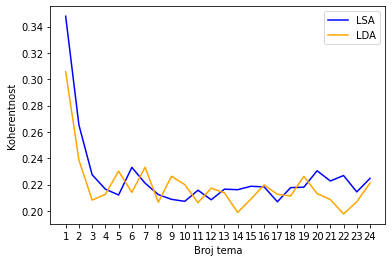

In [23]:
plt.plot(range(1, 25), coherences_lsa, color='blue', label='LSA')
plt.plot(range(1, 25), coherences_lda, color='orange', label='LDA')
plt.legend()
plt.xticks(range(1, 25))
plt.xlabel('Broj tema')
plt.ylabel('Koherentnost')
plt.show()

U ovom eksperimentu, LSA i LDA se pokazuju prilično bliskim. Najbolji rezulati su se pokazali kada postavimo broj tema na 6 ili na 20. Ovaj rezultat ima smisla, jer postoji 20 tema, ali su neke teme slične (npr. postoji tema za PC hardver i tema za *Mac* hardver), te se izdvaja oko 6 kategorija sličnih tema.

## Zaključak

LSA algoritam jeste intutivniji, ali je činjenica da je LDA metoda dosta popularnija i neretko efektivnija metoda tematskog modeliranja. Zgodna stvar kod ovih metoda jeste postojanje različitih gotovih implementacija, pa se vrlo jednostavno mogu koristiti kao "crne kutije"; te se problemi ovog tipa, koji su sve češći, mogu brzo i efikasno rešavati.

## Literatura:

[Topic Modeling with LSA, PLSA, LDA & lda2Vec](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05)

[Text Mining 101: A Stepwise Introduction to Topic Modeling using Latent Semantic Analysis (using Python)](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/)

[Topic Modelling with LSA and LDA](https://forestforthetree.com/statistics/2018/01/28/topic-modelling-with-lsa-and-lda.html)

[Intuitive Guide to Latent Dirichlet Allocation](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

[Latent Dirichlet Allocation, original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)

[Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)